### Extract File Folders SKU 21 Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path  

sku = "File Folders SKU 21"
path_file = "0926_my_data_sku_"+sku+".csv"
my_data_sku = pd.read_table(path_file,delimiter=',')
print(my_data_sku)



                     sku  salesdate  price  unitsordered  sales   cogs    fba  \
0    File Folders SKU 21  2/16/2022  17.99           2.0   36.0    9.0   13.0   
1    File Folders SKU 21  2/17/2022  17.99           1.0   18.0    4.0    7.0   
2    File Folders SKU 21  2/18/2022  17.99           1.0   18.0    4.0    7.0   
3    File Folders SKU 21  2/20/2022  17.99           1.0   18.0    4.0    7.0   
4    File Folders SKU 21  2/21/2022  17.99           1.0   18.0    4.0    7.0   
..                   ...        ...    ...           ...    ...    ...    ...   
577  File Folders SKU 21  9/19/2023  18.49          39.0  721.0  173.0  257.0   
578  File Folders SKU 21  9/20/2023  18.49          24.0  444.0  107.0  158.0   
579  File Folders SKU 21  9/21/2023  18.49          27.0  499.0  120.0  178.0   
580  File Folders SKU 21  9/22/2023  18.49          13.0  240.0   58.0   86.0   
581  File Folders SKU 21  9/23/2023  18.49           8.0  148.0   36.0   53.0   

     reffee  adspend  profi

In [2]:
from scipy.spatial.distance import cdist
import cvxpy as cp

def formulate_demand_pmf(price_Tr, comp_1_price_Tr, price_Te0, comp_1_price_Te0, sigma):
    # Non-parametric estimate of demand distribution
    #           Input:
    #        price_Tr: training samples for price
    # comp_1_price_Tr: training samples from competitor's price
    #       price_Te0: target price
    #comp_1_price_Te0: target competitor's price
    #           sigma: bandwidth
    #          Output:
    #      pmf_demand: pmf of demand distribution, supported on [demand_Tr]

    pmf_demand_exponent = (price_Te0 - price_Tr)**2 + (comp_1_price_Te0 - comp_1_price_Tr) ** 2
    pmf_demand = np.exp(-pmf_demand_exponent/sigma)
    pmf_demand = pmf_demand / np.sum(pmf_demand)
    return pmf_demand

def WDRO_demand_calculate(pmf_demand, unitsordered_Tr, price_Te0, epsilon):
    # WDRO Estimator of Robust Demand Distribution and Robust Profit
    #           Input:
    #      pmf_demand: nominal demand distribution
    # unitsordered_Tr: training samples for demand
    #       price_Te0: target price
    #         epsilon: size of ambiguity set
    #          Output:
    #               x: Robust Demand Distribution

    a_1=4.43965609
    a_2=6.60097822
    N = len(pmf_demand)
    cost_hist = 0.85*price_Te0*unitsordered_Tr - (a_1 + a_2) * unitsordered_Tr

    pmf_demand = pmf_demand.reshape([-1,1])
    cost_hist  = cost_hist.reshape([-1,1])
    unitsordered_Tr = unitsordered_Tr.reshape([-1,1])

    cost_unitsordered_Tr = cdist(unitsordered_Tr, unitsordered_Tr, 'sqeuclidean')
    x = cp.Variable(N)
    gamma = cp.Variable([N,N])

    obj = cp.Minimize(cost_hist.T@x)
    constrat = [gamma >=0, 
                cp.sum(cp.multiply(gamma, cost_unitsordered_Tr)) <= epsilon, 
                cp.sum(gamma,1) == pmf_demand.reshape([-1,]),
                cp.sum(gamma,0) == x]
    prob = cp.Problem(obj,constrat)
    prob.solve()
    return x.value, np.sum(x.value.reshape([-1,1]) * cost_hist), np.sum(pmf_demand * cost_hist)

def WDRO_demand_calculate_optimistic(pmf_demand, unitsordered_Tr, price_Te0, epsilon):
    # WDRO Estimator of Optimistic Demand Distribution and Optimistic Profit
    #           Input:
    #      pmf_demand: nominal demand distribution
    # unitsordered_Tr: training samples for demand
    #       price_Te0: target price
    #         epsilon: size of ambiguity set
    #          Output:
    #               x: Optimistic Demand Distribution

    a_1=4.43965609
    a_2=6.60097822
    N = len(pmf_demand)
    cost_hist = 0.85*price_Te0*unitsordered_Tr - (a_1 + a_2) * unitsordered_Tr

    pmf_demand = pmf_demand.reshape([-1,1])
    cost_hist  = cost_hist.reshape([-1,1])
    unitsordered_Tr = unitsordered_Tr.reshape([-1,1])

    cost_unitsordered_Tr = cdist(unitsordered_Tr, unitsordered_Tr, 'sqeuclidean')
    x = cp.Variable(N)
    gamma = cp.Variable([N,N])

    obj = cp.Maximize(cost_hist.T@x)
    constrat = [gamma >=0, 
                cp.sum(cp.multiply(gamma, cost_unitsordered_Tr)) <= epsilon, 
                cp.sum(gamma,1) == pmf_demand.reshape([-1,]),
                cp.sum(gamma,0) == x]
    prob = cp.Problem(obj,constrat)
    prob.solve()
    return x.value, np.sum(x.value.reshape([-1,1]) * cost_hist), np.sum(pmf_demand * cost_hist)


In [14]:
price                   = my_data_sku["price"].to_numpy()
unitsordered            = my_data_sku["unitsordered"].to_numpy()
comp_1_price            = my_data_sku["comp_1_price"].to_numpy()
managed_fba_stock_level = my_data_sku["managed_fba_stock_level"].to_numpy()
adspend                 = my_data_sku["adspend"].to_numpy()
profit                  = my_data_sku["profit"].to_numpy()

idx_hist = np.where(unitsordered < managed_fba_stock_level)

price_Tr_True        = price[idx_hist[0]]
comp_1_price_Tr_True = comp_1_price[idx_hist[0]]
unitsordered_Tr_True = unitsordered[idx_hist[0]]

price_Te_hist = np.load("price_Te_hist.npy")

sigma = 1
epsilon = 5

Demand_mean_hist = []

for i in range(len(price_Te_hist)):
    price_Te0        = price_Te_hist[i]
    comp_1_price_Te0 = 22.99
    if price_Te0 >= 17.49:

        pmf_demand_Tr_Te = formulate_demand_pmf(price_Tr_True, comp_1_price_Tr_True, price_Te0, comp_1_price_Te0, sigma)
        pmf_demand_Tr_Te_robust, profit_robust, profit_ERM = WDRO_demand_calculate(pmf_demand_Tr_Te, unitsordered_Tr_True, price_Te0, epsilon**2)
        pmf_demand_Tr_Te_optimistic, profit_optimistic, profit_ERM = WDRO_demand_calculate_optimistic(pmf_demand_Tr_Te, unitsordered_Tr_True, price_Te0, epsilon**2)
        
        Demand_mean_hist.append([price_Te0, 
                                 np.sum(pmf_demand_Tr_Te * unitsordered_Tr_True),
                                 np.sum(pmf_demand_Tr_Te_robust * unitsordered_Tr_True), 
                                 np.sum(pmf_demand_Tr_Te_optimistic * unitsordered_Tr_True), ])
        print(Demand_mean_hist[-1])

Demand_mean_hist = np.array(Demand_mean_hist)
print(Demand_mean_hist)

[17.549999999999965, 20.36862101141291, 15.388034091689455, 25.30918538391887]
[17.589999999999964, 20.37808144067275, 15.397326120899834, 25.318748997314472]
[17.649999999999963, 20.387761315886305, 15.406754470691322, 25.32863390469059]
[17.689999999999962, 20.39129049865292, 15.410116937685439, 25.332332242185753]
[17.74999999999996, 20.392341346592293, 15.410919529616084, 25.333683690839514]
[17.78999999999996, 20.39029793376478, 15.408712076608765, 25.331870741950866]
[17.84999999999996, 20.383264555050005, 15.401435143069126, 25.32522619079251]
[17.889999999999958, 20.37601793999154, 15.394028013455474, 25.318266299831222]
[17.949999999999957, 20.361464738017858, 15.379237114285072, 25.304182296140347]
[17.989999999999956, 20.34939791062616, 15.367014028906363, 25.29245305356858]
[18.049999999999955, 20.327908304001248, 15.345293593589505, 25.271504752607438]
[18.089999999999954, 20.31141514404749, 15.328649052535145, 25.255394422080517]
[18.149999999999952, 20.28358522317682, 15

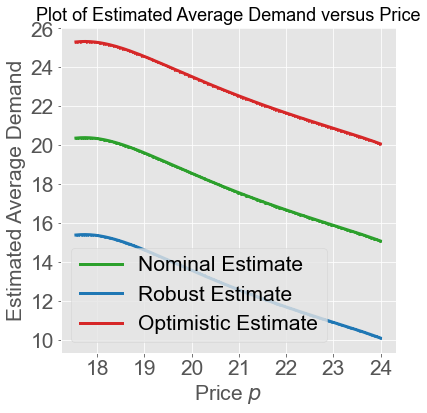

In [44]:
plt.rcParams["font.family"] = "arial"
plt.style.use("ggplot")
fig, axes = plt.subplots(figsize=(6,6))
axes.plot(Demand_mean_hist[:,0], Demand_mean_hist[:,1], label=r'Nominal Estimate', 
            linestyle = '-', marker = 'o', color='tab:green',ms=2,linewidth=3)
axes.plot(Demand_mean_hist[:,0], Demand_mean_hist[:,2], label=r'Robust Estimate', 
            linestyle = '-', marker = '<', color='tab:blue',ms=2,linewidth=3)
axes.plot(Demand_mean_hist[:,0], Demand_mean_hist[:,3], label=r'Optimistic Estimate', 
            linestyle = '-', marker = '>', color='tab:red',ms=2,linewidth=3)

axes.legend(loc="best",fontsize=21)
axes.set_xlabel(r'Price $p$', fontsize=21)
axes.set_ylabel(r'Estimated Average Demand', fontsize=21)

plt.xticks(fontsize=21)
plt.yticks(fontsize=21)

plt.title(r'Plot of Estimated Average Demand versus Price',fontsize=18)

plt.savefig("demand_summary.pdf",bbox_to_anchor="tight")


#plt.savefig("Profit_estimator.pdf",bbox_to_anchor="tight")


<Figure size 432x288 with 0 Axes>

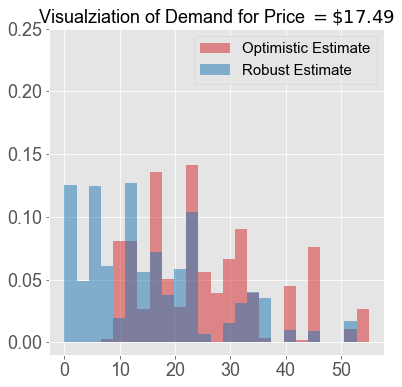

<Figure size 432x288 with 0 Axes>

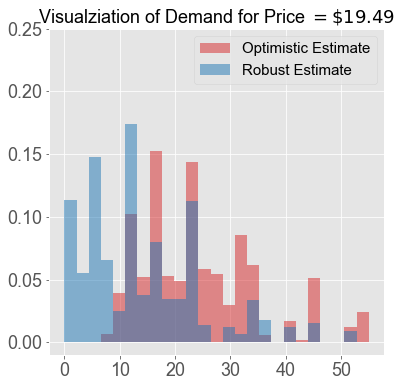

<Figure size 432x288 with 0 Axes>

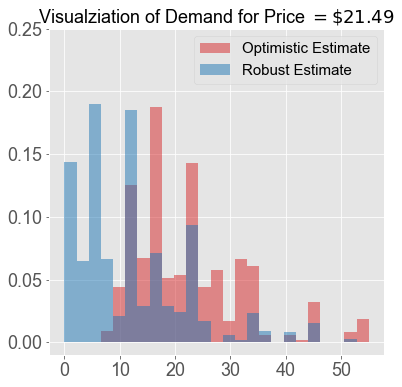

<Figure size 432x288 with 0 Axes>

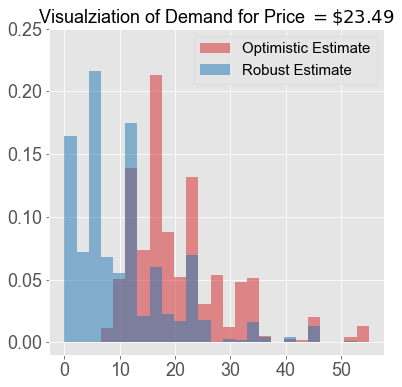

In [45]:
comp_1_price_Te0 = 22.99
######################################################################
########## Plotting for Price = 17.49 ################################
######################################################################
price_Te0                         = 17.49
pmf_demand_Tr_Te                  = formulate_demand_pmf(price_Tr_True, comp_1_price_Tr_True, price_Te0, comp_1_price_Te0, sigma)
pmf_demand_Tr_Te_robust, _, _     = WDRO_demand_calculate(pmf_demand_Tr_Te, unitsordered_Tr_True, price_Te0, epsilon**2)
pmf_demand_Tr_Te_optimistic, _, _ = WDRO_demand_calculate_optimistic(pmf_demand_Tr_Te, unitsordered_Tr_True, price_Te0, epsilon**2)


plt.figure()
fig, axes = plt.subplots(figsize=(6,6))
plt.style.use("ggplot")
plt.hist(unitsordered_Tr_True,bins=25, color='tab:red', label="Optimistic Estimate",
             weights=pmf_demand_Tr_Te_optimistic,alpha=0.5)
plt.hist(unitsordered_Tr_True,bins=25, color='tab:blue', label="Robust Estimate",
             weights=pmf_demand_Tr_Te_robust,alpha=0.5)
plt.legend(fontsize=15,loc=1)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([-0.01,0.25])
plt.title(r'Visualziation of Demand for Price $=\$17.49$',fontsize=18)
plt.savefig('Plot_Histogram_Demand_1.pdf',bbox_inches='tight')


######################################################################
########## Plotting for Price = 19.49 ################################
######################################################################
price_Te0                         = 19.49
pmf_demand_Tr_Te                  = formulate_demand_pmf(price_Tr_True, comp_1_price_Tr_True, price_Te0, comp_1_price_Te0, sigma)
pmf_demand_Tr_Te_robust, _, _     = WDRO_demand_calculate(pmf_demand_Tr_Te, unitsordered_Tr_True, price_Te0, epsilon**2)
pmf_demand_Tr_Te_optimistic, _, _ = WDRO_demand_calculate_optimistic(pmf_demand_Tr_Te, unitsordered_Tr_True, price_Te0, epsilon**2)


plt.figure()
fig, axes = plt.subplots(figsize=(6,6))
plt.style.use("ggplot")
plt.hist(unitsordered_Tr_True,bins=25, color='tab:red', label="Optimistic Estimate",
             weights=pmf_demand_Tr_Te_optimistic,alpha=0.5)
plt.hist(unitsordered_Tr_True,bins=25, color='tab:blue', label="Robust Estimate",
             weights=pmf_demand_Tr_Te_robust,alpha=0.5)
plt.legend(fontsize=15,loc=1)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([-0.01,0.25])
plt.title(r'Visualziation of Demand for Price $=\$19.49$',fontsize=18)
plt.savefig('Plot_Histogram_Demand_2.pdf',bbox_inches='tight')



######################################################################
########## Plotting for Price = 21.49 ################################
######################################################################
price_Te0                         = 21.49
pmf_demand_Tr_Te                  = formulate_demand_pmf(price_Tr_True, comp_1_price_Tr_True, price_Te0, comp_1_price_Te0, sigma)
pmf_demand_Tr_Te_robust, _, _     = WDRO_demand_calculate(pmf_demand_Tr_Te, unitsordered_Tr_True, price_Te0, epsilon**2)
pmf_demand_Tr_Te_optimistic, _, _ = WDRO_demand_calculate_optimistic(pmf_demand_Tr_Te, unitsordered_Tr_True, price_Te0, epsilon**2)


plt.figure()
fig, axes = plt.subplots(figsize=(6,6))
plt.style.use("ggplot")
plt.hist(unitsordered_Tr_True,bins=25, color='tab:red', label="Optimistic Estimate",
             weights=pmf_demand_Tr_Te_optimistic,alpha=0.5)
plt.hist(unitsordered_Tr_True,bins=25, color='tab:blue', label="Robust Estimate",
             weights=pmf_demand_Tr_Te_robust,alpha=0.5)
plt.legend(fontsize=15,loc=1)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([-0.01,0.25])
plt.title(r'Visualziation of Demand for Price $=\$21.49$',fontsize=18)
plt.savefig('Plot_Histogram_Demand_3.pdf',bbox_inches='tight')



######################################################################
########## Plotting for Price = 23.49 ################################
######################################################################
price_Te0                         = 23.49
pmf_demand_Tr_Te                  = formulate_demand_pmf(price_Tr_True, comp_1_price_Tr_True, price_Te0, comp_1_price_Te0, sigma)
pmf_demand_Tr_Te_robust, _, _     = WDRO_demand_calculate(pmf_demand_Tr_Te, unitsordered_Tr_True, price_Te0, epsilon**2)
pmf_demand_Tr_Te_optimistic, _, _ = WDRO_demand_calculate_optimistic(pmf_demand_Tr_Te, unitsordered_Tr_True, price_Te0, epsilon**2)


plt.figure()
fig, axes = plt.subplots(figsize=(6,6))
plt.style.use("ggplot")
plt.hist(unitsordered_Tr_True,bins=25, color='tab:red', label="Optimistic Estimate",
             weights=pmf_demand_Tr_Te_optimistic,alpha=0.5)
plt.hist(unitsordered_Tr_True,bins=25, color='tab:blue', label="Robust Estimate",
             weights=pmf_demand_Tr_Te_robust,alpha=0.5)
plt.legend(fontsize=15,loc=1)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([-0.01,0.25])
plt.title(r'Visualziation of Demand for Price $=\$23.49$',fontsize=18)
plt.savefig('Plot_Histogram_Demand_4.pdf',bbox_inches='tight')
